In [2]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from scipy.io import netcdf
import matplotlib.pyplot as plt 

In [ ]:
# read the original t.s. data
time_series_df = feather.read_feather('dataset/time_series/original_data_as_feather')

In [ ]:
# cut the t.s. range to be from 01.01.1995 to 31.12.2012 
df = time_series_df[time_series_df["date"]>"1995-01-01 00:00:00+00:00"]
df = df[df["date"] < "2013-01-01 00:00:00+00:00"]
df.to_csv("dataset/time_series/t_s_95-2012.csv",index=False)

In [ ]:
# drop name and index columns ,some cleaning
t_s_chunklist = []
t_s_df = pd.read_csv("dataset/time_series/t_s_95_2012.csv", chunksize = 10e6)

for chunk in t_s_df:
    t_s_chunklist.append(chunk.drop(chunk.columns[[0, 2]], axis=1))

df = pd.concat(t_s_chunklist)
df.to_csv("filtered_t_s.csv",index=False)

In [ ]:
####################

In [ ]:
t_s_chunklist = []
t_s_df = pd.read_csv("dataset/time_series/filtered_t_s.csv", chunksize = 10e6)

In [ ]:
# convert timestamp to str similar to temp file datum
for chunk in t_s_df:
    chunk["day"] = chunk["date"].apply(lambda x:"".join(x[:10].split("-")))
    t_s_chunklist.append(chunk)
df = pd.concat(t_s_chunklist)

#df.to_csv("dataset/filtered_t_s.csv",index=False)

### transforming t s into 2d space with time and location as coordinates

In [ ]:
# group t.s. according to the dates and proj_id
df = pd.read_csv("dataset/time_series/filtered_t_s.csv")
grouped_t_s = df[["proj_id","day", "groundwater_level"]].groupby(["proj_id","day"]).mean().unstack()
grouped_t_s.head()

In [ ]:
# adjust the df, drop the first level to get 2-dim df
grouped_t_s.columns= grouped_t_s.columns.droplevel(0)
grouped_t_s

In [ ]:
# save previous changes into csv file
#grouped_t_s.to_csv("dataset/grouped_t_s.csv", index = True)

In [6]:
# read grouped t.s again from cvs file 
grouped_t_s =pd.read_csv("dataset/time_series/grouped_t_s.csv")
grouped_t_s.head()

,proj_id,19950101,19950102,19950103,19950104,19950105,19950106,19950107,19950108,19950109,...,20121222,20121223,20121224,20121225,20121226,20121227,20121228,20121229,20121230,20121231
0,BB_25470023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BB_25470024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BB_25480025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BB_25480026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BB_25481088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.28,37.32,37.33,37.35,37.33,37.35,37.3,37.31,37.34,37.34


In [7]:
# set proj_id as index
grouped_t_s = grouped_t_s.set_index("proj_id")
grouped_t_s.head()

,19950101,19950102,19950103,19950104,19950105,19950106,19950107,19950108,19950109,19950110,...,20121222,20121223,20121224,20121225,20121226,20121227,20121228,20121229,20121230,20121231
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25470024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25481088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.28,37.32,37.33,37.35,37.33,37.35,37.3,37.31,37.34,37.34


In [8]:
grouped_t_s.shape

(12825, 6575)

### over 17 years (1995-2012) we have about 816 weeks
### i.e. we should consider a bout 800 measures in each t s if they were taken weekly

### In grouped_t_s : there are 12825 time series, the groundwater level measured in 6575 days.  the measures did not occur in the same dates for all the stations i.e. we cannot determine a specific set of dates for all T.S and predictors 

In [ ]:
# trying to drop some columns(days) that have less than 1000 values -over all stations 
filter_some_days= grouped_t_s.loc[ :, (grouped_t_s.notnull().sum(axis=0) > 1000)]
filter_some_days

### in 6575 - 5459 = 1116 days, the measurs of ground water level occured in less than 1000 stations (of 12850) 

In [ ]:
# check how many t s have less then 800 measures in this filtered df
( filter_some_days.notnull().sum(axis=1)<800).sum()


### in this filter: out of 12825 t s, 4984 t s have less than 800 values (time points)
### i.e there are not takeń weekly

In [ ]:
# check the t.s that has less than 800 values in general
(grouped_t_s.notnull().sum(axis=1)<800).sum()


### in general: 4803 t s  have less than 800 values (before the filter)

# plot some t s (without any filter)

In [ ]:
grouped_t_s.head()

<AxesSubplot:label='cd70f05a-89e8-496e-8dcf-a5f1606b1099'>

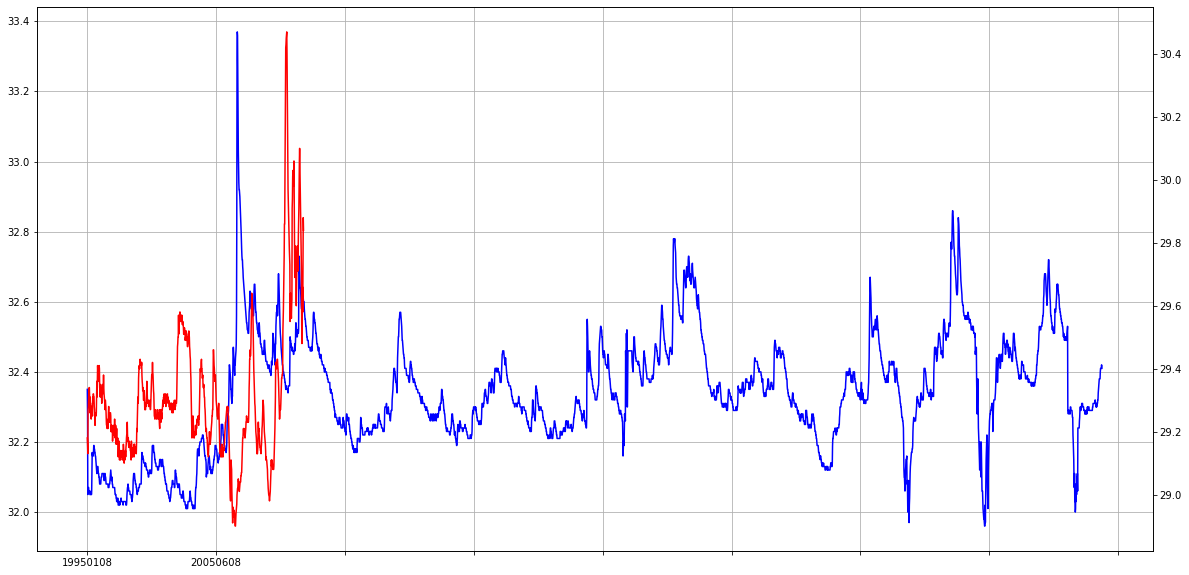

In [9]:
plt.figure(figsize=(20,10))

grouped_t_s.iloc[100].dropna().plot(color='blue',grid=True)
grouped_t_s.iloc[5].dropna().plot(color='red',grid=True, secondary_y=True)

### the cooerdinate does not scale because the columns name  saved as str not date type 

In [ ]:
# number of time  points in the plotted t s
len(grouped_t_s.iloc[2].dropna())

### transform the type of the columns from str into date

In [ ]:
grouped_t_s_date_index = grouped_t_s.copy()
grouped_t_s_date_index.head()

# importe from here !!

In [ ]:
# save the previos grouped_t_s_date_index into csv 
# grouped_t_s_date_index.to_csv("dataset/time_series/grouped_t_s_date_index.csv")

In [4]:
# it is better for visualisation if the columns date type (not int or str)
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        new_columns.append(pd.to_datetime(col).date())
    return new_columns

In [11]:
# import t s and convert into date type
grouped_t_s = pd.read_csv("dataset/time_series/grouped_t_s_date_index.csv")
grouped_t_s = grouped_t_s.set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
grouped_t_s.head()

,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-12-22,2012-12-23,2012-12-24,2012-12-25,2012-12-26,2012-12-27,2012-12-28,2012-12-29,2012-12-30,2012-12-31
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25470024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25481088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.28,37.32,37.33,37.35,37.33,37.35,37.3,37.31,37.34,37.34


In [12]:
grouped_t_s.shape

(12825, 6575)

### sort t s in 5 level of frequeny: daily, mid_weekly between 2 to 5 days measures, weekly between 6 or 7 days  fortnight 8 to 14 days, and more than 2 weeks which will be filtered out

In [60]:
# create df for freq levels
freq_level = pd.DataFrame() 
freq_level["proj_id"]=grouped_t_s.index
freq_level[["daily", "mid_weekly","weekly","fortnight", "low_freq"]] = False
freq_level =freq_level.set_index("proj_id")
freq_level.head()

,daily,mid_weekly,weekly,fortnight,low_freq
proj_id,,,,,
BB_25470023,False,False,False,False,False
BB_25470024,False,False,False,False,False
BB_25480025,False,False,False,False,False
BB_25480026,False,False,False,False,False
BB_25481088,False,False,False,False,False


### moving to the frequency concept: because the t s measured in many diff dates, and some of them measured daily and others weekly or monthly

### some t s measured over only few of the 17 years

### it is better for the outlier detection to measure the freq of each t s , and then keeping the t s with high freq 

In [61]:
# use of frequency approach 
#compute the freq level of each t s, and set it in new df freq_level 
# used later to compute the predictors according to the freq_level

for i in range(len(grouped_t_s)):
    
    ts = grouped_t_s.iloc[i].dropna()
    num_of_values = ts.shape[0]
    if num_of_values != 0:
        first = ts.index[0]
        last  = ts.index[-1]
        num_days = (last - first).days +1 # num days from the start to the end of the measures 
        period = int(num_days/num_of_values)
        if period ==1:
            freq_level.iat[i,0]=True
        elif 1 < period < 5:
            freq_level.iat[i,1]=True
        elif 5 < period < 8:
            freq_level.iat[i,2]=True
        elif 8 < period < 15:
            freq_level.iat[i,3]=True
        else :
            freq_level.iat[i,4]=True

            



In [85]:
# save a freq level df of t s into a csv
#freq_level.to_csv("dataset/time_series/freq_level.csv")

In [73]:
# here we see the t s with high freq
grouped_t_s[freq_level["low_freq"]==False]

,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-12-22,2012-12-23,2012-12-24,2012-12-25,2012-12-26,2012-12-27,2012-12-28,2012-12-29,2012-12-30,2012-12-31
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.62000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25470024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.45000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.29000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.37000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25481088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.28000,37.32000,37.33000,37.35000,37.33000,37.35000,37.30000,37.31000,37.34000,37.34000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TH_5633900046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,343.20550,343.29300,343.23425,343.29475,343.32275,343.48200,343.24875,343.47150,343.42325,343.52500
TH_5633900056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,367.48000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TH_5633900114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,429.20225,429.36575,429.41075,429.46200,429.45575,429.46675,429.44025,429.42175,429.47775,429.46825


In [83]:
# to check a freq level of a t s
freq_level.loc["TH_5633900046"].index[freq_level.loc["TH_5633900046"]==True][0]


'daily'

In [86]:
# keep only t s with high freq (period less than 2 weeks)
grouped_t_s = grouped_t_s[freq_level["low_freq"]==False]
grouped_t_s

,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-12-22,2012-12-23,2012-12-24,2012-12-25,2012-12-26,2012-12-27,2012-12-28,2012-12-29,2012-12-30,2012-12-31
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.62000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25470024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.45000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.29000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.37000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25481088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.28000,37.32000,37.33000,37.35000,37.33000,37.35000,37.30000,37.31000,37.34000,37.34000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TH_5633900046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,343.20550,343.29300,343.23425,343.29475,343.32275,343.48200,343.24875,343.47150,343.42325,343.52500
TH_5633900056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,367.48000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TH_5633900114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,429.20225,429.36575,429.41075,429.46200,429.45575,429.46675,429.44025,429.42175,429.47775,429.46825


In [93]:
# drop out all t s that have less than 500 values -> 1677 t s
df =grouped_t_s[grouped_t_s.notnull().sum(axis=1)>500]


<ipython-input-93-0b2246c551b9>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[freq_level["low_freq"]==False]


,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-12-22,2012-12-23,2012-12-24,2012-12-25,2012-12-26,2012-12-27,2012-12-28,2012-12-29,2012-12-30,2012-12-31
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.62000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25470024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.45000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.29000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.37000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25481088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.28000,37.32000,37.33000,37.35000,37.33000,37.35000,37.30000,37.31000,37.34000,37.34000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TH_5632240510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,360.77300,360.82725,360.88175,360.97000,360.97550,361.03025,360.99700,361.04300,361.08200,361.08175
TH_5633000078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,351.63700,351.77225,351.90300,351.82300,351.75525,351.73325,351.85375,351.80125,351.73675,351.67650
TH_5633900008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,346.94750,347.47800,347.40850,347.36850,347.34350,347.36800,347.08225,347.04900,347.06150,347.09850


In [ ]:
# store t s with high freq and high num of time points
high_freq_t_s = df[freq_level["low_freq"]==False]
high_freq_t_s.to_csv("dataset/time_series/high_freq")

In [5]:
#import the final df and set index and transform the columns to date
high_freq_t_s = pd.read_csv("dataset/time_series/high_freq_t_s.csv")
high_freq_t_s = high_freq_t_s.set_index("proj_id")
high_freq_t_s.columns = convert_col_to_date(high_freq_t_s.columns)
high_freq_t_s.head()

,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,1995-01-09,1995-01-10,...,2012-12-22,2012-12-23,2012-12-24,2012-12-25,2012-12-26,2012-12-27,2012-12-28,2012-12-29,2012-12-30,2012-12-31
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25470023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25470024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25480026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_25481088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.28,37.32,37.33,37.35,37.33,37.35,37.3,37.31,37.34,37.34


<AxesSubplot:label='123ca087-6340-4b4f-91a2-844b703a7b97'>

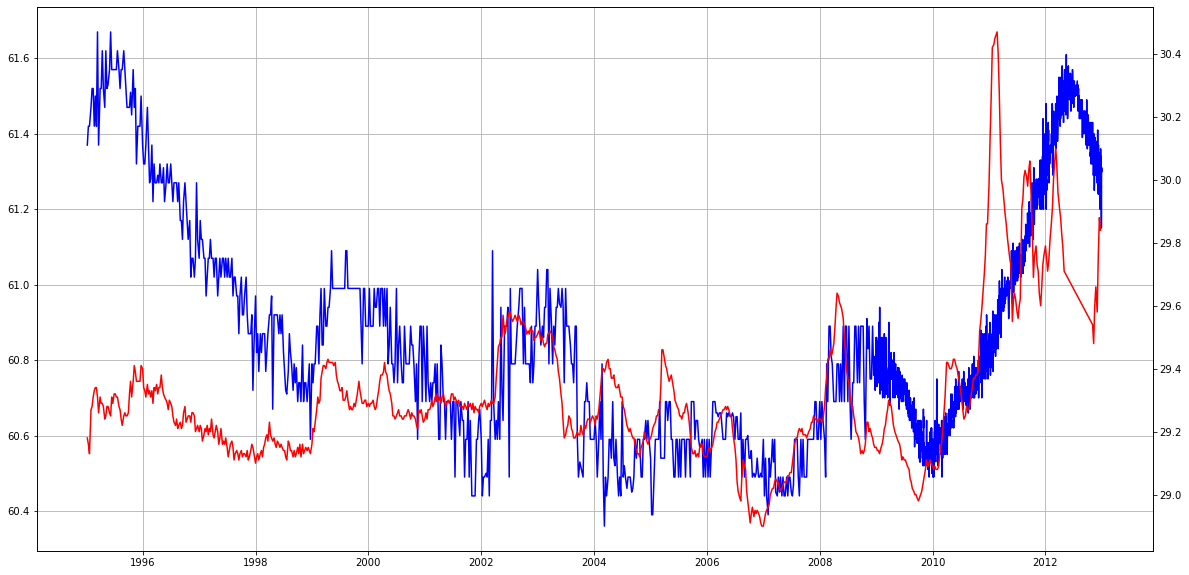

In [8]:
plt.figure(figsize=(20,10))

high_freq_t_s.iloc[5000].dropna().plot(color='blue',grid=True)
high_freq_t_s.iloc[5].dropna().plot(color='red',grid=True, secondary_y=True)

In [19]:
high_freq_t_s.shape

(8922, 6575)

## finally there are 8922 t s to work with , we should find the corresponding temperature and precipitation for modelling

### we compute the temp on average and precipitation on sum according to the freq level, 

In [ ]:
#####################''''''

In [ ]:
# check the memory usage
grouped_t_s.memory_usage().sum()

In [2]:
freq_level = pd.read_csv("dataset/time_series/freq_level.csv")

In [5]:
freq_level.head()

,proj_id,daily,mid_weekly,weekly,fortnight,low_freq
0,BB_25470023,False,False,True,False,False
1,BB_25470024,False,False,True,False,False
2,BB_25480025,False,False,True,False,False
3,BB_25480026,False,False,True,False,False
4,BB_25481088,True,False,False,False,False


In [13]:
freq_level[freq_level["daily"]].shape

(3109, 6)